In [1]:
import pandas as pd
import numpy as np
from bq_helper import BigQueryHelper
from blockchain import blockexplorer
from blockchain import util
import time
from tqdm import tqdm
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

In [9]:
from google.cloud import bigquery

In [2]:
util.TIMEOUT = 15

In [3]:
# unit in satoshi
address = blockexplorer.get_address('3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB')
address2 = blockexplorer.get_address('3EXxYoB61g13UsH1K678G5zeEE8W3XJ2p3')
address3 = blockexplorer.get_address('1NqdBaU9WCvmjGQ1omPx6NHGJYzQo9udd6')
print(address.total_received)
print(address.total_sent)
print(address.final_balance)
print(address.n_tx)
print(address.transactions[0].hash)

655000000000
654990000000
10000000
43
c7ae6fb55b5919bf8239555a11f0309527bac4f18bdc5b9f98fbcd7bf7e83342


idea: use bfs to expand adr to explore. 

for simplicity, neglect amount of transfer for now

for transacitons going out of Target Address, not so interested right now

problem: how to distinguish incoming or outgoing tx?

timeout: The read operation timed out
possible solution: request API key?

before: want to search by distance/radius. now: search by number of nodes to visit

neo4j: transaction/address as vertex. inputs. outputs. 

In [21]:
tx = address.transactions[0]
print(tx.inputs[2].address)
print (addr_queue[0])

AttributeError: 'str' object has no attribute 'transactions'

In [13]:
address = '3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB'
total_received = blockexplorer.get_address(address).total_received
top_k = 5
tx_queue = []
addr_queue = []
leaf_dict = dict()
addr_queue.append((address, 0))
addr_dict = dict() # key:str address, value: number of visits
degree = 2
degree_count = 0
max_iter = 1
G=nx.DiGraph()
while degree > 0:
    print ("doing degree = " + str(degree_count) + " search, " + "number of nodes to explore (with duplicates): " + str(max_iter))
    for i in range(max_iter):
        if len(addr_queue) == 0:
            print ("max_iter not reached. All possible addresses explored.")
            break;
        address, amount = addr_queue.pop(0)
        G.add_node(address)
         # this process is slow
        if address not in addr_dict:
            addr = blockexplorer.get_address(address)
            if len(addr.transactions) == 1:
                leaf_dict[addr.address] = addr.total_sent
            tx_queue.extend(addr.transactions)
            addr_dict[address] = amount
            #print (address)
        else:
            addr_dict[address] += amount
        while len(tx_queue) > 0:
            tx = tx_queue.pop(0)
            isReceiver = False;
            # check if this addr is receiving money
            money_received = 0
            for out in tx.outputs:
                if addr.address == out.address:
                    #if len(tx.outputs) > 1 and len(tx.inputs) > 1:
                        #print (addr.address)
                        #print(tx.hash)
                    isReceiver = True;
                    money_received = out.value
                    break;
            if isReceiver:
                for inp in tx.inputs:
                    # algorithm here could be wrong
                    if inp.value < money_received:
                        money_received -= inp.value
                        money_edge = inp.value
                    else:
                        money_edge = money_received
                    G.add_weighted_edges_from([(inp.address, addr.address, money_edge)])
                    addr_queue.append((inp.address, money_edge))
    max_iter = len(addr_queue)
    degree -= 1
    degree_count += 1
    print ("degree " + str(degree_count)+ " total number of nodes " + str(len(G)))
    scores = Counter(addr_dict)
    total = 0
    for addr, values in scores.most_common(top_k):
        total += values
        print (addr, values, str(values/total_received * 100) + "%")
    print ("top " + str(top_k) +" addresses total:  " + str(total) + "    " +str(total/total_received*100) + "%")

doing degree = 0 search, number of nodes to explore (with duplicates): 1
degree 1 total number of nodes 84
3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB 0 0.0%
top 5 addresses total:  0    0.0%
doing degree = 1 search, number of nodes to explore (with duplicates): 91
degree 2 total number of nodes 453
39ACzDZRJBd1STHgvL5AMQvo48iqMoEdSS 30000000000 4.580152671755725%
3PpXuqu2KG4WZmHyFp2XyU5gmaFDxmxJJ1 25000000000 3.816793893129771%
3QxkG5HitPoXsjTfogMk4AYqj4TJhJnZGH 25000000000 3.816793893129771%
3CLon2XMt7yBuVrqtPBw5cW9o93dJeAknM 25000000000 3.816793893129771%
3E9CYFsCiDtQ4xaxsj1hcZLUh8hwpimioj 25000000000 3.816793893129771%
top 5 addresses total:  130000000000    19.84732824427481%


In [14]:
print (len(leaf_dict))

0


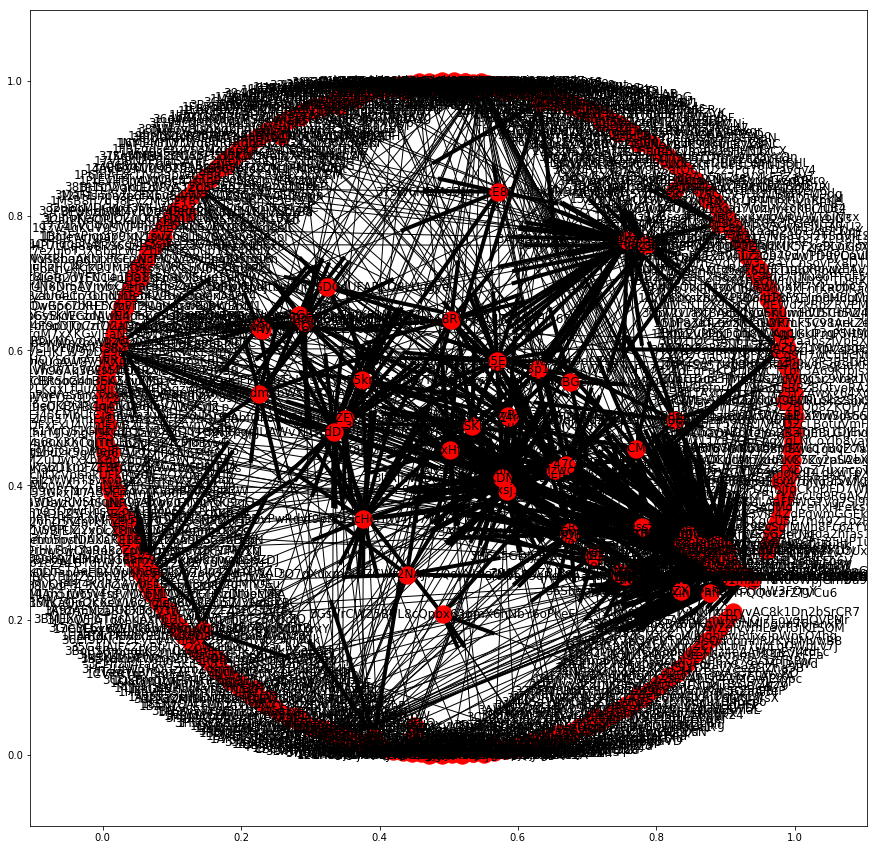

In [8]:
matplotlib.rcParams['figure.figsize'] = [15, 15] 
nx.draw_networkx(G)
plt.show()

In [9]:
print (len(addr_queue))
print (max_iter)

1183
1183


Explanation: After use BFS to visit first 1000 (with duplicates)addresses, there are in fact 415 unique nodes. And the nodes to be explored reach 21080. Total time taken locally is 10min. 

With this much exploration: top 5 addresses are listed above, the number associated is the number of transactions related to TA. '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s' is an interesting one with 285 transacitons. (Maybe should count total number of transacitons related to TA, but this metric can be changed into amount of BTC later)

In [37]:
TA = blockexplorer.get_address('3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB')
print (TA.total_received)
scores = Counter(addr_dict)
total = 0
for addr, values in scores.most_common(len(addr_dict)):
    total += values
    print (addr, values, str(values/TA.total_received * 100) + "%")
print ("total   " + str(total) + "    " +str(total/TA.total_received*100) + "%")

655000000000
39ACzDZRJBd1STHgvL5AMQvo48iqMoEdSS 30000000000 4.580152671755725%
3PpXuqu2KG4WZmHyFp2XyU5gmaFDxmxJJ1 25000000000 3.816793893129771%
3QxkG5HitPoXsjTfogMk4AYqj4TJhJnZGH 25000000000 3.816793893129771%
3CLon2XMt7yBuVrqtPBw5cW9o93dJeAknM 25000000000 3.816793893129771%
3E9CYFsCiDtQ4xaxsj1hcZLUh8hwpimioj 25000000000 3.816793893129771%
3QiLXF8tpa17k9XLZ4rbcoXTKJDoWsNaGG 20000000000 3.0534351145038165%
3MWaY5qReHm3qqnhgYCE437cVD4moWeUys 20000000000 3.0534351145038165%
33SBjyCNDr499kFkg93nxchtRg9ij38H2C 20000000000 3.0534351145038165%
3QEvTTqJ5eCcXYy2p7jJEtqH4xFnyCjXme 20000000000 3.0534351145038165%
37D1iDiquoAW875RXjvPc6HRgsmsLriDbo 20000000000 3.0534351145038165%
3N9R1K7r8veTLK16qZGKpP1CVdyKYBmGsc 20000000000 3.0534351145038165%
3ESJe7jsjhJrHk9dkvvbqYfscRnrZnwSJx 20000000000 3.0534351145038165%
3AzK8em6MeGgZkvDnrzRQS1p1dS4Hkg9KY 20000000000 3.0534351145038165%
3E7DcbGJ3XEzffUCKHQw9HorzLc5NiiANC 20000000000 3.0534351145038165%
3L9M3qzpoQh4jxaj9iNRx3zxgxB23SJFJZ 20000000000 3.05343